# Доставка пиццы

Есть приложение для курьеров по доставке пиццы. 

Есть несколько ресторанов в разных частях города и целый штат курьеров. 

Есть проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены доставка очень сильно проседает в эффективности. 

Был придуман новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. Чтобы курьеры доставляли последние свои заказы "по пути" домой. 

Решено провести A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию. 

<b>Задача</b>: проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

<b>Описание данных</b>

- order_id - id заказа
- delivery_time - время доставки в минутах
- district - район доставки
- experiment_group - экспериментальная группа

Сформулируем гипотезы:

- Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет.
- Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from scipy import stats

In [2]:
data = pd.read_csv('experiment_lesson_4.csv')

In [3]:
data.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


In [5]:
# всего 3 района доставки
data.district.unique()

array(['Purlieus', 'Central', 'Suburb'], dtype=object)

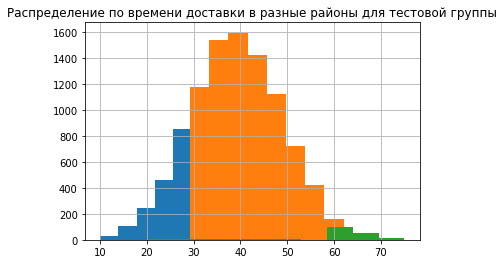

In [6]:
data.query('experiment_group == "test"').groupby('district').delivery_time.hist()
plt.title('Распределение по времени доставки в разные районы для тестовой группы');

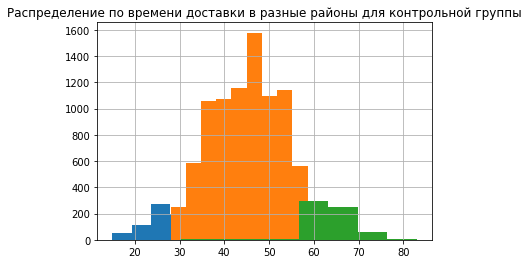

In [7]:
data.query('experiment_group == "control"').groupby('district').delivery_time.hist()
plt.title('Распределение по времени доставки в разные районы для контрольной группы');

In [8]:
# количество наблюдений для контрольной группы
count_control = data.query('experiment_group == "control"').order_id.count()
count_control

10092

In [9]:
# количество наблюдений для тестовой группы
count_test = data.query('experiment_group == "test"').order_id.count()
count_test

10104

In [10]:
# разница в кол-ве наблюдений
abs(count_control - count_test)

12

Теперь изучим распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

Обычно нормальность тестируют с помощью теста Шапиро-Уилка, однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности. Поэтому используем функцию scipy.stats.normaltest() - она больше адаптирована к большим выборкам.

In [11]:
delivery_test = data.query('experiment_group == "test"').delivery_time
delivery_control = data.query('experiment_group == "control"').delivery_time

In [12]:
# проверка выборки тестовых на нормальность тестом Агостино-Пирсона - выборка ненормально распределена
normaltest(delivery_test)

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

In [13]:
# проверка выборки контрольных на нормальность тестом Агостино-Пирсона - выборка нормально распределена
normaltest(delivery_control)

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

In [14]:
# стандартное отклонение выборки тестовых
round(np.std(delivery_test), 2)

9.88

In [15]:
# стандартное отклонение выборки контрольных
round(np.std(delivery_control), 2)

9.99

Распределение выборки с тестовыми курьерами ненормальное, однако если посмотреть на саму форму распределения, то оно не настолько сильно нарушает нормальность, чтобы об этом беспокоиться на таком размере выборки.

Сравним средние в тесте и контроле. 

In [16]:
# среднее тестовой выборки
mean_test = delivery_test.mean()
mean_test

39.04681314330958

In [17]:
# среднее контрольной выборки
mean_control = delivery_control.mean()
mean_control

45.065101070154576

In [18]:
# t-test сравнения двух средних, p-value < 0.05, отклоняем нулевую гипотезу, средние статистически различаются
stats.ttest_ind(delivery_test, delivery_control)

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [19]:
# на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной?
round((mean_test - mean_control) / mean_control * 100, 2)

-13.35

Так как среднее время доставки статистически значимо изменилось и среднее время доставки в тесте меньше, чем в контроле, - раскатываем новый алгоритм на всех курьеров.

## Вывод

В ходе данной работы было сделано:
- сформулировали нулевую и альтернативную гипотезу
- визуализировали графики распределения скорости доставки в разные районы в экспериментальных группах
- посчитали количество наблюдений в разных группах
- проверили выборки на нормальность тестом Агостино-Пирсона
- посчитали стандартные отклонения выборок
- сравнили средние в выборках с помощью t-test
- посчитали, на сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной
- сделали вывод по проведенному эксперименту - можем запускать новый алгоритм для всех пользователей приложения